In [ ]:
!pip install umap-learn sentence-transformers bertopic pymorphy2

In [3]:
import re
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from umap import UMAP
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN, KMeans, HDBSCAN, SpectralClustering, AgglomerativeClustering
from sentence_transformers import SentenceTransformer
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score as ss
from sklearn.metrics.pairwise import cosine_distances
from scipy.spatial.distance import mahalanobis
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import pymorphy2
import plotly.express as px
import pickle

In [4]:
nltk.download('punkt')
morph = pymorphy2.MorphAnalyzer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
with open('/content/Crime And Punishment.txt') as file:
  data = [line.strip() for line in file]
data = [i for i in data if i !='']
data = data[143:]

In [6]:
text = list()
for paragraph in data:
    text.extend(nltk.sent_tokenize(paragraph))

In [7]:
def clean_part(text):
    text = [re.sub(r'(\w)-с([^\w\s])', r'\1\2', i) for i in text]
    text = [re.sub(r'\[\d+\]', '', i) for i in text]
    text = [re.sub(r'[^\w\s]', '', i) for i in text]
    text = [re.sub(r'\s+', ' ', i).strip() for i in text]
    text = [' '.join([word for word in paragraph.split() if word not in stop_words]) for paragraph in text]
    text = [i for i in text if len(i.split()) > 2]
    text = [' '.join([morph.parse(word)[0].normal_form for word in line.split()]) for line in text]
    return text
nltk.download('stopwords')
stop_words = stopwords.words('russian') + ['это', 'Ну', 'да', 'тебе', 'он', 'но', 'ты', 'вы', 'Это', 'Да', 'Он']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Изначально хотел сделать анализ каждый части, потом соединить и получить общую картину. Но ни в интернете, ни в доках не нашел нормального способа(

In [8]:
part_one = clean_part(text[:text.index('Часть вторая')])
part_two = clean_part(text[text.index('Часть вторая')+1:text.index('Часть третья')])
part_three = clean_part(text[text.index('Часть третья')+1:text.index('Часть четвертая')])
part_four = clean_part(text[text.index('Часть четвертая')+1:text.index('Часть пятая')])
part_five = clean_part(text[text.index('Часть пятая')+1:text.index('Часть шестая')])
part_six = clean_part(text[text.index('Часть шестая')+1:text.index('Эпилог')])
part_epilogue = clean_part(text[text.index('Эпилог')+1:])
all_parts = [part_one, part_two, part_three, part_four, part_five, part_six, part_epilogue]

In [9]:
cleaned_text = []
for i in all_parts:
    cleaned_text.extend(i)

## Евклидово расстояние

In [14]:
embedding_model = SentenceTransformer('ai-forever/sbert_large_nlu_ru')
hdbscan_model = HDBSCAN(metric='euclidean', min_samples=20)
vect_model = CountVectorizer(ngram_range=(1, 3), stop_words=stop_words)
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True, bm25_weighting=True)
topic_model = BERTopic(embedding_model=embedding_model, hdbscan_model=hdbscan_model, vectorizer_model=vect_model, ctfidf_model=ctfidf_model, top_n_words=10, verbose=True)

In [ ]:
topics, probabilities = topic_model.fit_transform(cleaned_text)

2024-07-31 17:46:04,987 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/327 [00:00<?, ?it/s]

2024-07-31 18:23:01,891 - BERTopic - Embedding - Completed ✓
2024-07-31 18:23:01,896 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-07-31 18:23:43,767 - BERTopic - Dimensionality - Completed ✓
2024-07-31 18:23:43,771 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-07-31 18:23:45,740 - BERTopic - Cluster - Completed ✓
2024-07-31 18:23:45,756 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-07-31 18:23:47,752 - BERTopic - Representation - Completed ✓


In [ ]:
topic_model.save("/content/drive/MyDrive/Colab Notebooks/model_eucl", serialization="pickle")

2024-07-31 20:43:49,818 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [ ]:
topic_model.get_topics()

{-1: [('ваш', 0.08995131743361208),
  ('слово', 0.08938614542251438),
  ('рука', 0.08691543689383315),
  ('человек', 0.08637208462379303),
  ('который', 0.08618843264215946),
  ('видеть', 0.08534498529645497),
  ('мочь', 0.08500644287932538),
  ('сказать', 0.08445602314739066),
  ('весь', 0.08445215769455562),
  ('свой', 0.0842191868497125)],
 0: [('дверь', 0.23299807520929317),
  ('лестница', 0.22053149749587012),
  ('комната', 0.20865252665855766),
  ('квартира', 0.20098030351931895),
  ('этаж', 0.19626010027160212),
  ('дом', 0.18082657657218795),
  ('отворить', 0.17748860139263745),
  ('запереть', 0.172880119298016),
  ('улица', 0.16422512547764354),
  ('окно', 0.1625666694342465)],
 1: [('раскольник', 0.31999916656938615),
  ('раскольников', 0.28049119322265303),
  ('раскольник раскольник', 0.22065285554336092),
  ('спросить раскольник', 0.1852076715147312),
  ('проговорить раскольник', 0.1779134846435021),
  ('подумать раскольник', 0.177668819831793),
  ('ответить раскольник', 0.

Давайте посмотрим на некоторые результат и попробуем найти темы, понятные для нас:
<br> 0 - "дверь, лестница, квартира, комната" - речь о комнате в которой жил гг и комнате старухи процентщицы
<br> 1 - "раскольников" - речь о главном герое (гг)
<br> 2 - "рубль, деньги, тысяча" - речь о деньгах, главном мотиваторе преступления гг.
<br> 4 - "перешагнуть, ошибка, убеждение" - речь о душевных терзаниях гг.
<br> 5 - "пить, вино, пиво" - речь о вредных привичных, которыми, например, обладал отец Сони - Семен Захарович
<br> 7 - "письмо, книга, читать" - речь о письме матери гг.
<br> 12 - "бог, господь, иисус" - речь об отношении гг и Сони к религии


In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_documents(cleaned_text)

Output hidden; open in https://colab.research.google.com to view.

Видим, что все нормально прокластеризировалось. Можно сделать двойной клик по интересующей теме в легенде. (Обратно - также двойной клик)

### Код, который сделает эмбеддинги для ключевых слов топиков. Затем посчитает косинусные расстояния и сгруппирует темы

In [ ]:
def get_word_embeddings(words, model):
    return model.encode(words)

# Получаем эмбеддинги для слов каждой темы
topic_embeddings = {}
for topic_id, words in topic_model.get_topics().items():
    word_list = [word for word, _ in words]
    embeddings = get_word_embeddings(word_list, embedding_model)
    topic_embeddings[topic_id] = embeddings

In [ ]:
def average_embedding(embeddings):
    return np.mean(embeddings, axis=0)

average_topic_embeddings = {topic_id: average_embedding(embeddings) for topic_id, embeddings in topic_embeddings.items()}
threshold = 0.20
merged_topics = {}
visited = set()

for topic_id1, emb1 in average_topic_embeddings.items():
    if topic_id1 in visited:
        continue

    merged_topics[topic_id1] = [topic_id1]
    visited.add(topic_id1)

    for topic_id2, emb2 in average_topic_embeddings.items():
        if topic_id1 != topic_id2 and topic_id2 not in visited:
            distance = cosine_distances([emb1], [emb2])[0][0]
            if distance < threshold:
                merged_topics[topic_id1].append(topic_id2)
                visited.add(topic_id2)
merged_topics

{-1: [-1, 2, 4, 12, 13, 14, 18, 28, 34, 37, 39, 41, 45, 54, 56],
 0: [0],
 1: [1],
 3: [3, 11],
 5: [5],
 6: [6],
 7: [7, 50],
 8: [8],
 9: [9],
 10: [10],
 15: [15, 16, 26, 44, 52, 63, 65, 66, 68, 69, 73, 75],
 17: [17, 19],
 20: [20],
 21: [21],
 22: [22, 74],
 23: [23],
 24: [24],
 25: [25],
 27: [27],
 29: [29, 70, 77],
 30: [30],
 31: [31],
 32: [32],
 33: [33],
 35: [35],
 36: [36, 71],
 38: [38],
 40: [40],
 42: [42],
 43: [43],
 46: [46],
 47: [47],
 48: [48],
 49: [49],
 51: [51],
 53: [53],
 55: [55],
 57: [57],
 58: [58],
 59: [59],
 60: [60],
 61: [61],
 62: [62],
 64: [64],
 67: [67],
 72: [72],
 76: [76]}

## Расстояние Хэмминга

In [9]:
hdbscan_model_2 = HDBSCAN(metric='hamming', min_cluster_size=20)

In [23]:
topic_model_2 = BERTopic(embedding_model=embedding_model, hdbscan_model=hdbscan_model_2, vectorizer_model=vect_model, ctfidf_model=ctfidf_model, top_n_words=10, verbose=True)

In [24]:
topics_2, probabilities_2 = topic_model_2.fit_transform(cleaned_text)

2024-08-01 09:29:31,002 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/327 [00:00<?, ?it/s]

2024-08-01 10:08:13,643 - BERTopic - Embedding - Completed ✓
2024-08-01 10:08:13,646 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-08-01 10:08:59,692 - BERTopic - Dimensionality - Completed ✓
2024-08-01 10:08:59,696 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-08-01 10:09:01,656 - BERTopic - Cluster - Completed ✓
2024-08-01 10:09:01,691 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-08-01 10:09:03,957 - BERTopic - Representation - Completed ✓


In [28]:
topic_model_2.get_topics()

{-1: [('ваш', 0.09318986456288955),
  ('слово', 0.0914571098511699),
  ('человек', 0.08900145230404688),
  ('сказать', 0.08869879907861415),
  ('дело', 0.08850537186209187),
  ('свой', 0.08838775170893977),
  ('весь', 0.08823363919939972),
  ('мочь', 0.08821609624484661),
  ('который', 0.0879674225439819),
  ('видеть', 0.08790393015915203)],
 0: [('дверь', 0.23329106000273148),
  ('лестница', 0.2214993403260493),
  ('комната', 0.21041616559864126),
  ('квартира', 0.20059241070980557),
  ('этаж', 0.19863121558684194),
  ('дом', 0.18336153677665215),
  ('отворить', 0.17167189311873943),
  ('окно', 0.16758783553270676),
  ('улица', 0.1667439572968619),
  ('запереть', 0.16461501790180932)],
 1: [('раскольник', 0.3239481034820463),
  ('раскольников', 0.28663861160853504),
  ('раскольник раскольник', 0.21429427677169308),
  ('спросить раскольник', 0.18542302573405134),
  ('проговорить раскольник', 0.17845634619211256),
  ('раскольников раскольник', 0.1728951474252865),
  ('подумать раскольни

Темы здесь похожие с первой модели, но тут их чуть меньше.

In [29]:
topic_model_2.visualize_documents(cleaned_text)

Output hidden; open in https://colab.research.google.com to view.

## Манхэттенское расстояние

In [13]:
hdbscan_model_3 = HDBSCAN(metric='manhattan', min_samples=20)
topic_model_3 = BERTopic(embedding_model=embedding_model, hdbscan_model=hdbscan_model_3, vectorizer_model=vect_model, ctfidf_model=ctfidf_model, top_n_words=10, verbose=True)

In [14]:
topics_3, probabilities_3 = topic_model_3.fit_transform(cleaned_text)

2024-08-01 05:50:20,358 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/327 [00:00<?, ?it/s]

2024-08-01 06:29:08,260 - BERTopic - Embedding - Completed ✓
2024-08-01 06:29:08,262 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-08-01 06:29:55,014 - BERTopic - Dimensionality - Completed ✓
2024-08-01 06:29:55,019 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-08-01 06:29:56,233 - BERTopic - Cluster - Completed ✓
2024-08-01 06:29:56,261 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-08-01 06:29:57,593 - BERTopic - Representation - Completed ✓


In [16]:
topic_model_3.get_topics()

{0: [('знать', 0.25717052636187465),
  ('свой', 0.25252129543457885),
  ('раскольник', 0.2502663235097572),
  ('сказать', 0.24833720485609492),
  ('говорить', 0.2442266853774157),
  ('человек', 0.24366993847389282),
  ('мочь', 0.2400331305185724),
  ('весь', 0.23833506661163703),
  ('стать', 0.2350263006953215),
  ('который', 0.23413682714978679)],
 1: [('cinq sous', 1.3014389192479434),
  ('cinq', 1.3014389192479434),
  ('sous', 1.3014389192479434),
  ('du', 1.1022157011637783),
  ('sous cinq sous', 0.9779819889331205),
  ('cinq sous cinq', 0.9779819889331205),
  ('sous cinq', 0.9779819889331205),
  ('la', 0.9545467976579094),
  ('пофранцузски', 0.9202562851003124),
  ('willst du mehr', 0.8241375084389004)]}

In [15]:
topic_model_3.visualize_documents(cleaned_text)

Output hidden; open in https://colab.research.google.com to view.

## Можно сравнить это с обычной моделью из кластеризации

(до этого я подбирал с помощью метода локтя кол-во классов для kmeans, 6-7 оптимально)

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

In [24]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(cleaned_text)
# X = np.array(X)

In [25]:
model = KMeans(random_state=10, n_clusters=6)
model.fit(X)
label_encoder = LabelEncoder()
normalized_labels = label_encoder.fit_transform(model.labels_)

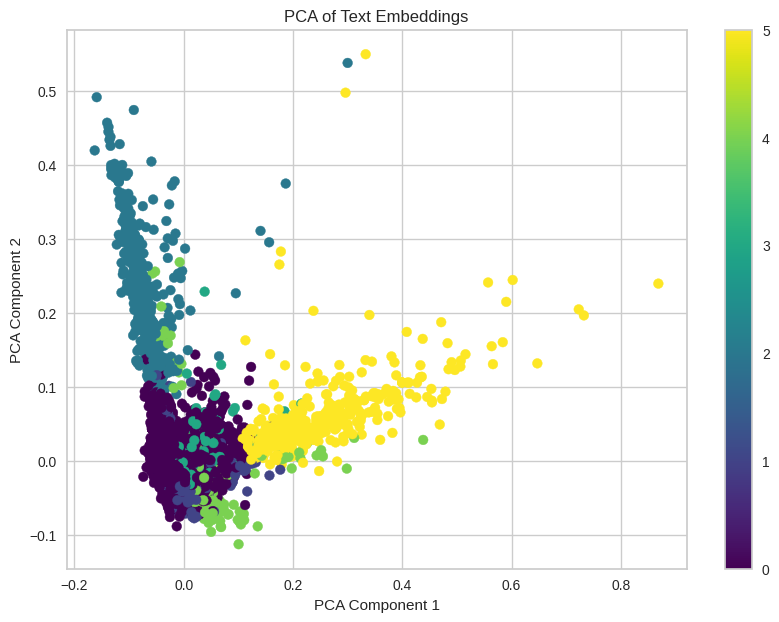

In [27]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Снижение размерности до 2D для визуализации
pca = PCA(n_components=2)
reduced_X = pca.fit_transform(X.toarray())

plt.figure(figsize=(10, 7))
scatter = plt.scatter(reduced_X[:, 0], reduced_X[:, 1], c=normalized_labels, cmap='viridis')
plt.colorbar(scatter)

plt.title('PCA of Text Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()



In [45]:
indices_5 = [i for i, x in enumerate(normalized_labels) if x == 1]
fifth_class = pd.Series(cleaned_text)[indices_5]
fifth_class.values[:15]

array(['в начало июль чрезвычайно жаркое время вечер молодой человек выйти свой каморка который нанимать жилец смотреть переулок улица медленно нерешимость отправиться кну мост',
       'квартирный хозяйка который нанимать каморка обед прислуга помещаться один лестница ниже отдельный квартира каждый выход улица непременно проходить мимо хозяйкин кухня настежь отворить лестница',
       'и каждый молодой человек проходить мимо чувствовать какоеть болезненный трусливый ощущение который стыдиться который морщиться',
       'гм рука человек всеть мимо нос проносить единственно один трусость аксиома любопытно человек бояться',
       'чувство глубокий омерзение мелькнуть миг тонкий черта молодой человек',
       'худо одетый иной привычный человек посовеститься день выходить такой лохмотья улица',
       'но столько злобный презрение накопиться душа молодой человек несмотря очень молодой щекотливость менее совеститься свой лохмотья улица',
       'другой дело встреча иной знакомый прежний т

In [44]:
indices_2 = [i for i, x in enumerate(normalized_labels) if x == 2]
second_class = pd.Series(cleaned_text)[indices_2]
second_class.values[:15]

array(['раскольник студент назад тот месяц поспешить пробормотать молодой человек полупоклон вспомнить любезный',
       'так такой делец продолжать раскольник немного смутиться удивляться недоверчивость старуха',
       'раскольник выйти решительный смущение',
       'долго думать раскольник тотчас спуститься вниз',
       'раскольник привыкнуть толпа сказать бежать всякий общество особенно последний время',
       'нет случаться отвечать раскольник',
       'раскольник слушать внимательно',
       'раскольник слушать напряжённо ощущение болезненный',
       'раскольник тотчас признать катерина иванович',
       'уходить раскольник успеть просунуть рука карман загреб сколько прийтись медный деньга достаться разменять распивочный рубль неприметно положить окошко',
       'я делать нехотя сурово проговорить раскольник',
       'закричать весь волнение раскольник господь',
       'ясно иной родион романович раскольник ход первый план стоить',
       'раскольник сесть уйти хотеть стоять о

## Выводы:
BERTopic:

1я и 2я моедль сработали +- одинаково. А вот 3я модель решила сделать другое разделение: русские слова и французские слова из песни Катерины Ивановны

<br> 1я и 2я моедль сработали очень хорошо. Если проанализировать их результаты, то можно выделить следущие скрытые темы: деньги, алкоголь, душевные терзания, религия, преступление и тд.

<br> Если же поискать в интернете, что пишут люди о темах в этом произведении, то после обобщения получим: нищета, внутренние переживания, свобода, добро/зло, пьянство, Бог, смысл жизни.
Да, есть некоторые различия, но сходства очевидны.
(https://www.chitalnya.ru/work/3669297/, https://obrazovaka.ru/sochinenie/prestuplenie-i-nakazanie/analiz-proizvedeniya-dostoevskogo.html, https://mogu-pisat.ru/stat/konspekt/?ELEMENT_ID=432475)


<br>Кластеризация классика:

Модель смогла разделить на классы. Допустим, в 2ой класс она отнесла все про главного героя. Связь в других же классах уловить сложнее.
Ее, конечно, можно улучшить, добавить эмбеддинги, umap, но тогда мы получим первые 3 блока Bertopic и сравнить будет мало смысла.